In [1]:
#import required packages
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas_gbq
import plotly.graph_objs as go
import plotly as ply
import chart_studio.plotly as py
import dash
import dash_html_components as html
import dash_core_components as dcc
from dash.dependencies import Input, Output

In [2]:
#setting notebook figuure size
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]



In [3]:
#Filter variables
Deals = 'TBiz BB Capped Advanced'

#'TBiz BB Capped Advanced' 7846
# Unlimited Home Fibre 20Mbps (24 Month) 7277
# DDI Range Offer 10103
# 'Waya-Waya Pre-Paid Offer' 126112
# Enterprise Internet 805
# Router Card and Switches 6977
# Unlimited Business Fibre (20 Mbps) 24 Months 5136
# Business ECDSL Bundle 36252
# Deregulated PABX 43258
# Unlimited Business DSL (4Mbps) M2M 24500

In [4]:
#query from BigQuery
#must be ordered by ORDER_CREATION_DATE

query = """
SELECT *
FROM `bcx-insights.telkom_customerexperience.orders_20190926_00_anon`
WHERE DEAL_DESC = '{}'
ORDER BY ORDER_CREATION_DATE, ACTION_CREATION_DATE, ORDER_ID_ANON
""".format(Deals)

In [5]:
query

"\nSELECT *\nFROM `bcx-insights.telkom_customerexperience.orders_20190926_00_anon`\nWHERE DEAL_DESC = 'TBiz BB Capped Advanced'\nORDER BY ORDER_CREATION_DATE, ACTION_CREATION_DATE, ORDER_ID_ANON\n"

In [6]:
#create order dataframe
orders_df = pd.read_gbq(query,
                project_id = 'bcx-insights',
                dialect = 'standard')

In [7]:
len(orders_df)

7846

In [8]:
orders_df = orders_df.drop_duplicates()

In [9]:
len(orders_df)

6816

In [10]:
orders_df.head()

,ORDER_STATUS_DESC,ORDER_CREATION_DATE,ACTION_STATUS_DESC,ACTION_TYPE,ACTION_TYPE_DESC,ACTION_CREATION_DATE,ORIGINAL_SALES_CHANNEL_DESC,CURRENT_SALES_CHANNEL_DESC,DEAL_DESC,PROV_DATE,CLOSE_DATE,OPEN_CLOSE_INDIC,SOURCE,ORDER_ID_ANON,ACCOUNT_NO_ANON,MSISDN_ANON,ORDER_ACTION_ID_ANON
0,Done,2018-09-19 00:01:40+00:00,Done,CR,Resume from Suspension due to Collection,2018-09-19 00:00:34+00:00,Call Center,Call Center,TBiz BB Capped Advanced,2018-09-19 23:59:59+00:00,2018-09-19 02:02:36+00:00,C,F,8014743664010143874,4880988462641041588,8267334465643049670,-22945164240823800
2,Done,2018-09-19 00:08:19+00:00,Done,CR,Resume from Suspension due to Collection,2018-09-19 00:02:30+00:00,Call Center,Call Center,TBiz BB Capped Advanced,2018-09-19 23:59:59+00:00,2018-09-19 02:02:46+00:00,C,F,4896610020755115874,4880988462641041588,5883010122451860359,6206333873489587611
4,Done,2018-09-19 00:08:22+00:00,Done,CR,Resume from Suspension due to Collection,2018-09-19 00:08:04+00:00,Call Center,Call Center,TBiz BB Capped Advanced,2018-09-19 23:59:59+00:00,2018-09-19 02:03:30+00:00,C,F,-7402119597778060068,-7190704940419402037,6881390640784013810,1589287855847731834
6,Done,2018-09-19 00:11:18+00:00,Done,CR,Resume from Suspension due to Collection,2018-09-19 00:11:16+00:00,Call Center,Call Center,TBiz BB Capped Advanced,2018-09-19 23:59:59+00:00,2018-09-19 02:35:04+00:00,C,F,-891254573908734095,-1202927280942112478,-7917274003366893655,7874500299927321830
8,Done,2018-09-19 00:11:26+00:00,Done,CR,Resume from Suspension due to Collection,2018-09-19 00:11:25+00:00,Call Center,Call Center,TBiz BB Capped Advanced,2018-09-19 23:59:59+00:00,2018-09-19 02:08:45+00:00,C,F,-4980229336441433325,-1202927280942112478,-3858268071889160291,-6140598406575839500


In [11]:
orders_df['MSISDN_ANON'] = orders_df['MSISDN_ANON'].astype(str)

In [12]:
orders_df['ORDER_ID_ANON'] = orders_df['ORDER_ID_ANON'].astype(str)

In [13]:
unique_col = 'combo'

In [14]:
orders_df[unique_col] = orders_df['MSISDN_ANON']+'_'+orders_df['ORDER_ID_ANON']

In [15]:
orders_df['stage'] = orders_df.groupby(unique_col).cumcount()+1

In [16]:
final_stage = orders_df[[unique_col,'stage', 'ORDER_CREATION_DATE']].groupby(unique_col).agg({'stage': 'max', 'ORDER_CREATION_DATE': ['min', 'max']})

In [17]:
final_stage.head()

ORDER_CREATION_DATE  \
                                                                min   
combo                                                                 
-1002689210467033689_-4097911263059863394 2019-06-10 13:55:28+00:00   
-1002689210467033689_-4708518482210045078 2019-06-10 13:44:49+00:00   
-1002689210467033689_-6805338612372424491 2019-08-29 06:26:56+00:00   
-1002689210467033689_4694949585886651643  2019-07-16 02:47:00+00:00   
-1002689210467033689_6330235094427327840  2019-08-29 10:21:36+00:00   

                                                                    stage  
                                                                max   max  
combo                                                                      
-1002689210467033689_-4097911263059863394 2019-07-02 10:07:27+00:00     2  
-1002689210467033689_-4708518482210045078 2019-06-10 13:44:49+00:00     1  
-1002689210467033689_-6805338612372424491 2019-08-29 06:26:56+00:00     1  
-1002689210467033689_4694949585886651643  2019-07-16 02:47:00+00:00     1  
-1002689210467033689_6330235094427327840  2019-08-29 10:21:36+00:00     1

In [18]:
final_stage.columns = ["_".join(pair) for pair in final_stage.columns]

In [19]:
final_stage.rename(columns={'stage_max':'final_stage', 'ORDER_CREATION_DATE_min':'first_date', 'ORDER_CREATION_DATE_max':'last_date'}, inplace=True)

In [20]:
final_stage.head()

,first_date,last_date,final_stage
combo,,,
-1002689210467033689_-4097911263059863394,2019-06-10 13:55:28+00:00,2019-07-02 10:07:27+00:00,2
-1002689210467033689_-4708518482210045078,2019-06-10 13:44:49+00:00,2019-06-10 13:44:49+00:00,1
-1002689210467033689_-6805338612372424491,2019-08-29 06:26:56+00:00,2019-08-29 06:26:56+00:00,1
-1002689210467033689_4694949585886651643,2019-07-16 02:47:00+00:00,2019-07-16 02:47:00+00:00,1
-1002689210467033689_6330235094427327840,2019-08-29 10:21:36+00:00,2019-08-29 10:21:36+00:00,1


In [21]:
#final_stage['total_journey_length'] = final_stage['last_date'] - final_stage['first_date']

In [22]:
final_stage.head()

,first_date,last_date,final_stage
combo,,,
-1002689210467033689_-4097911263059863394,2019-06-10 13:55:28+00:00,2019-07-02 10:07:27+00:00,2
-1002689210467033689_-4708518482210045078,2019-06-10 13:44:49+00:00,2019-06-10 13:44:49+00:00,1
-1002689210467033689_-6805338612372424491,2019-08-29 06:26:56+00:00,2019-08-29 06:26:56+00:00,1
-1002689210467033689_4694949585886651643,2019-07-16 02:47:00+00:00,2019-07-16 02:47:00+00:00,1
-1002689210467033689_6330235094427327840,2019-08-29 10:21:36+00:00,2019-08-29 10:21:36+00:00,1


In [23]:
orders_df = pd.merge(orders_df, final_stage, on=unique_col, how='outer')

In [24]:
orders_df.head()

,ORDER_STATUS_DESC,ORDER_CREATION_DATE,ACTION_STATUS_DESC,ACTION_TYPE,ACTION_TYPE_DESC,ACTION_CREATION_DATE,ORIGINAL_SALES_CHANNEL_DESC,CURRENT_SALES_CHANNEL_DESC,DEAL_DESC,PROV_DATE,...,SOURCE,ORDER_ID_ANON,ACCOUNT_NO_ANON,MSISDN_ANON,ORDER_ACTION_ID_ANON,combo,stage,first_date,last_date,final_stage
0,Done,2018-09-19 00:01:40+00:00,Done,CR,Resume from Suspension due to Collection,2018-09-19 00:00:34+00:00,Call Center,Call Center,TBiz BB Capped Advanced,2018-09-19 23:59:59+00:00,...,F,8014743664010143874,4880988462641041588,8267334465643049670,-22945164240823800,8267334465643049670_8014743664010143874,1,2018-09-19 00:01:40+00:00,2018-09-19 00:01:40+00:00,1
1,Done,2018-09-19 00:08:19+00:00,Done,CR,Resume from Suspension due to Collection,2018-09-19 00:02:30+00:00,Call Center,Call Center,TBiz BB Capped Advanced,2018-09-19 23:59:59+00:00,...,F,4896610020755115874,4880988462641041588,5883010122451860359,6206333873489587611,5883010122451860359_4896610020755115874,1,2018-09-19 00:08:19+00:00,2018-09-19 00:08:19+00:00,1
2,Done,2018-09-19 00:08:22+00:00,Done,CR,Resume from Suspension due to Collection,2018-09-19 00:08:04+00:00,Call Center,Call Center,TBiz BB Capped Advanced,2018-09-19 23:59:59+00:00,...,F,-7402119597778060068,-7190704940419402037,6881390640784013810,1589287855847731834,6881390640784013810_-7402119597778060068,1,2018-09-19 00:08:22+00:00,2018-09-19 00:08:22+00:00,1
3,Done,2018-09-19 00:11:18+00:00,Done,CR,Resume from Suspension due to Collection,2018-09-19 00:11:16+00:00,Call Center,Call Center,TBiz BB Capped Advanced,2018-09-19 23:59:59+00:00,...,F,-891254573908734095,-1202927280942112478,-7917274003366893655,7874500299927321830,-7917274003366893655_-891254573908734095,1,2018-09-19 00:11:18+00:00,2018-09-19 00:11:18+00:00,1
4,Done,2018-09-19 00:11:26+00:00,Done,CR,Resume from Suspension due to Collection,2018-09-19 00:11:25+00:00,Call Center,Call Center,TBiz BB Capped Advanced,2018-09-19 23:59:59+00:00,...,F,-4980229336441433325,-1202927280942112478,-3858268071889160291,-6140598406575839500,-3858268071889160291_-4980229336441433325,1,2018-09-19 00:11:26+00:00,2018-09-19 00:11:26+00:00,1


In [25]:
orders_df['total_time'] = orders_df['ORDER_CREATION_DATE']-orders_df['first_date']

In [26]:
orders_df[orders_df['final_stage']==2].head()

,ORDER_STATUS_DESC,ORDER_CREATION_DATE,ACTION_STATUS_DESC,ACTION_TYPE,ACTION_TYPE_DESC,ACTION_CREATION_DATE,ORIGINAL_SALES_CHANNEL_DESC,CURRENT_SALES_CHANNEL_DESC,DEAL_DESC,PROV_DATE,...,ORDER_ID_ANON,ACCOUNT_NO_ANON,MSISDN_ANON,ORDER_ACTION_ID_ANON,combo,stage,first_date,last_date,final_stage,total_time
52,Cancelled,2018-09-19 10:20:39+00:00,Cancelled,CI,Cease Part Of Migrate,2018-09-19 00:00:00+00:00,Call Center,Call Center,TBiz BB Capped Advanced,1950-01-01 00:00:00+00:00,...,-798146561363310271,6512472196967755422,-163301983679457663,8269386966561002079,-163301983679457663_-798146561363310271,1,2018-09-19 10:20:39+00:00,2018-09-19 10:41:39+00:00,2,0 days 00:00:00
53,Done,2018-09-19 10:41:39+00:00,Done,CI,Cease Part Of Migrate,2018-09-19 00:00:00+00:00,Call Center,Call Center,TBiz BB Capped Advanced,2018-09-19 12:41:55+00:00,...,-798146561363310271,6512472196967755422,-163301983679457663,-8038438834520941868,-163301983679457663_-798146561363310271,2,2018-09-19 10:20:39+00:00,2018-09-19 10:41:39+00:00,2,0 days 00:21:00
147,Cancelled,2018-09-21 15:00:41+00:00,Cancelled,CI,Cease Part Of Migrate,2018-09-21 00:00:00+00:00,WNS SMBS Outbound,WNS SMBS Outbound,TBiz BB Capped Advanced,1950-01-01 00:00:00+00:00,...,1927791018406881593,8730648574707157456,-5476603457303044367,-6211388984143561759,-5476603457303044367_1927791018406881593,1,2018-09-21 15:00:41+00:00,2018-09-25 12:46:42+00:00,2,0 days 00:00:00
148,Done,2018-09-25 12:46:42+00:00,Done,CI,Cease Part Of Migrate,2018-09-21 00:00:00+00:00,WNS SMBS Outbound,WNS SMBS Outbound,TBiz BB Capped Advanced,2018-09-25 13:18:32+00:00,...,1927791018406881593,8730648574707157456,-5476603457303044367,-7765968125154275429,-5476603457303044367_1927791018406881593,2,2018-09-21 15:00:41+00:00,2018-09-25 12:46:42+00:00,2,3 days 21:46:01
274,Cancelled,2018-09-26 13:38:57+00:00,Cancelled,CH,Change,2018-09-26 00:00:00+00:00,Telkom Direct Shop,Telkom Direct Shop,TBiz BB Capped Advanced,1950-01-01 00:00:00+00:00,...,1311839235413350640,-5526670356510072085,-1737832741425107573,1353844975755891999,-1737832741425107573_1311839235413350640,1,2018-09-26 13:38:57+00:00,2018-10-02 13:58:35+00:00,2,0 days 00:00:00


In [27]:
orders_df['stage'] = orders_df['stage'].astype(str)

In [28]:
orders_df['ActionType_OrderStatus'] = orders_df['ACTION_TYPE_DESC'] +' * '+ orders_df['ORDER_STATUS_DESC'] 

In [29]:
type_status = list(sorted(orders_df['ActionType_OrderStatus'].unique()))

In [30]:
type_status

['Cease * Cancelled',
 'Cease * Delivery',
 'Cease * Done',
 'Cease * Negotiation',
 'Cease Part Of Migrate * Cancelled',
 'Cease Part Of Migrate * Completion',
 'Cease Part Of Migrate * Done',
 'Cease Part Of Migrate * Negotiation',
 'Cease Part Of Move * Cancelled',
 'Cease Part Of Move * Done',
 'Cease Part Of Move * Negotiation',
 'Cease due to Collection * Cancelled',
 'Cease due to Collection * Done',
 'Change * Cancelled',
 'Change * Done',
 'Change - Dispatchable * Cancelled',
 'Change - Dispatchable * Done',
 'Change - No Dispatch * Cancelled',
 'Change - No Dispatch * Done',
 'Change - T&M Dispatch * Cancelled',
 'Change - T&M Dispatch * Done',
 'Change BAN To BAN * Cancelled',
 'Change BAN To BAN * Done',
 'Change SN * Done',
 'Hard Suspend * Done',
 'Indoor transfer * Cancelled',
 'Indoor transfer * Done',
 'Modify Address * Done',
 'Modify Address * Negotiation',
 'Move Outdoor Other Exchange * Cancelled',
 'Move Outdoor Other Exchange * Done',
 'Move Outdoor Other Exchang

In [31]:
len(type_status)

49

In [32]:
max_string_len = len(max(type_status, key=len))
max_string_len

47

In [33]:
orders_df['stage_ActionType_OrderStatus'] = orders_df['stage'] +') * '+ orders_df['ACTION_TYPE_DESC'] +' * '+ orders_df['ORDER_STATUS_DESC'] 

In [34]:
orders_df.tail(3)

,ORDER_STATUS_DESC,ORDER_CREATION_DATE,ACTION_STATUS_DESC,ACTION_TYPE,ACTION_TYPE_DESC,ACTION_CREATION_DATE,ORIGINAL_SALES_CHANNEL_DESC,CURRENT_SALES_CHANNEL_DESC,DEAL_DESC,PROV_DATE,...,MSISDN_ANON,ORDER_ACTION_ID_ANON,combo,stage,first_date,last_date,final_stage,total_time,ActionType_OrderStatus,stage_ActionType_OrderStatus
6813,Done,2019-09-18 06:41:04+00:00,Done,HS,Hard Suspend,2019-09-18 06:41:04+00:00,Call Center,Call Center,TBiz BB Capped Advanced,2019-09-18 23:59:59+00:00,...,-3746220542732778290,-3107359610750660354,-3746220542732778290_-3623129877457504494,1,2019-09-18 06:41:04+00:00,2019-09-18 06:41:04+00:00,1,0 days,Hard Suspend * Done,1) * Hard Suspend * Done
6814,Done,2019-09-18 06:41:06+00:00,Done,HS,Hard Suspend,2019-09-18 06:41:05+00:00,Call Center,Call Center,TBiz BB Capped Advanced,2019-09-18 23:59:59+00:00,...,486548533846911321,5149598645928986403,486548533846911321_-4085417724732539719,1,2019-09-18 06:41:06+00:00,2019-09-18 06:41:06+00:00,1,0 days,Hard Suspend * Done,1) * Hard Suspend * Done
6815,Done,2019-09-18 06:41:14+00:00,Done,HS,Hard Suspend,2019-09-18 06:41:13+00:00,Call Center,Call Center,TBiz BB Capped Advanced,2019-09-18 23:59:59+00:00,...,-3379634856020541348,7366941129127761236,-3379634856020541348_-8459172821802969048,1,2019-09-18 06:41:14+00:00,2019-09-18 06:41:14+00:00,1,0 days,Hard Suspend * Done,1) * Hard Suspend * Done


In [35]:
#orders_df.groupby(unique_col)

In [36]:
customers = list(orders_df[unique_col].unique())

In [37]:
sorted_df = orders_df.sort_values('stage', ascending=False)
sorted_df.head(3)

,ORDER_STATUS_DESC,ORDER_CREATION_DATE,ACTION_STATUS_DESC,ACTION_TYPE,ACTION_TYPE_DESC,ACTION_CREATION_DATE,ORIGINAL_SALES_CHANNEL_DESC,CURRENT_SALES_CHANNEL_DESC,DEAL_DESC,PROV_DATE,...,MSISDN_ANON,ORDER_ACTION_ID_ANON,combo,stage,first_date,last_date,final_stage,total_time,ActionType_OrderStatus,stage_ActionType_OrderStatus
336,Done,2018-11-20 10:10:17+00:00,Done,MS,Move Outdoor Same Exchange,2018-08-27 00:00:00+00:00,Call Center,Call Center,TBiz BB Capped Advanced,2018-11-20 10:11:40+00:00,...,-5358406379613644979,-8130465519461665528,-5358406379613644979_4892878901532782903,4,2018-09-28 10:44:38+00:00,2018-11-20 10:10:17+00:00,4,52 days 23:25:39,Move Outdoor Same Exchange * Done,4) * Move Outdoor Same Exchange * Done
410,Done,2018-10-09 14:54:01+00:00,Done,MV,Move Outdoor Other Exchange,2018-10-02 00:00:00+00:00,Consumer Sales,Consumer Sales,TBiz BB Capped Advanced,2018-10-09 14:56:37+00:00,...,3842282672409691663,-4311406567201441950,3842282672409691663_4834273730448523809,4,2018-10-02 14:54:19+00:00,2018-10-09 14:54:01+00:00,4,6 days 23:59:42,Move Outdoor Other Exchange * Done,4) * Move Outdoor Other Exchange * Done
588,Done,2018-10-10 13:54:29+00:00,Done,PR,Provide,2018-10-10 00:00:00+00:00,Deregulated PABX Suppliers,Deregulated PABX Suppliers,TBiz BB Capped Advanced,2018-10-10 13:55:45+00:00,...,5100925659296341771,7122014269109539755,5100925659296341771_-152669041816858573,4,2018-10-10 13:43:57+00:00,2018-10-10 13:54:29+00:00,4,0 days 00:10:32,Provide * Done,4) * Provide * Done


In [38]:
len(orders_df[orders_df['stage']=='2'])

157

In [39]:
len(customers)

6650

In [40]:
# Create a networkx graph object
J = nx.Graph()

In [41]:
J.clear()

In [42]:
max_stage=max(orders_df['stage'].astype(int))
max_stage

4

In [43]:
actions = list(orders_df['stage_ActionType_OrderStatus'].unique())

In [44]:
#J.add_node(Deals[:3],posi=(0.4,10), color = 'purple', acc_time = 0, node_count = 1)

In [45]:
for i in range(1,max_stage+1):
  
  stage_actions = list(orders_df[orders_df['stage']==str(i)]['stage_ActionType_OrderStatus'].unique())
  #print(stage_actions)
  for k in range(len(stage_actions)):
    label = stage_actions[k]
    #print(label)
    #print(len(orders_df[orders_df['stage_ActionType_OrderStatus']==label]))
    label = label.split('* ',1)
    label = label[1]
    #print(label)
    height =  type_status.index(label) +1
    #print(height)
    #print(height)
    J.add_node(stage_actions[k],posi=((max_string_len*0.01)+(max_stage*0.01)+(i*1.25),height), acc_time = 0, node_count = len(orders_df[orders_df['stage_ActionType_OrderStatus']==stage_actions[k]]))
    #print(stage_actions[k])
    #print((i,k+1))

In [46]:
J.nodes(data = True)

NodeDataView({'2) * Move Outdoor Same Exchange * Cancelled': {'acc_time': 0, 'posi': (3.01, 33), 'node_count': 2}, '1) * Cease due to Collection * Done': {'acc_time': 0, 'posi': (1.76, 13), 'node_count': 262}, '1) * Cease due to Collection * Cancelled': {'acc_time': 0, 'posi': (1.76, 12), 'node_count': 2}, '2) * Cease Part Of Move * Cancelled': {'acc_time': 0, 'posi': (3.01, 9), 'node_count': 2}, '1) * Cease * Done': {'acc_time': 0, 'posi': (1.76, 3), 'node_count': 615}, '1) * Provide * Cancelled': {'acc_time': 0, 'posi': (1.76, 36), 'node_count': 22}, '4) * Move Outdoor Same Exchange * Done': {'acc_time': 0, 'posi': (5.51, 35), 'node_count': 1}, '1) * Move Outdoor Other Exchange * Done': {'acc_time': 0, 'posi': (1.76, 31), 'node_count': 4}, '3) * Provide * Done': {'acc_time': 0, 'posi': (4.26, 37), 'node_count': 1}, '1) * Resume from Suspension due to Collection * Done': {'acc_time': 0, 'posi': (1.76, 48), 'node_count': 1978}, '1) * Cease Part Of Move * Done': {'acc_time': 0, 'posi': 

In [47]:
#Create label nodes
L = nx.Graph()

In [48]:
for l in range(len(type_status)):
    label_start = type_status[l]
    height =  type_status.index(label_start) +1
    L.add_node(label_start,posi=(0.15,height))
    #print(label_start)

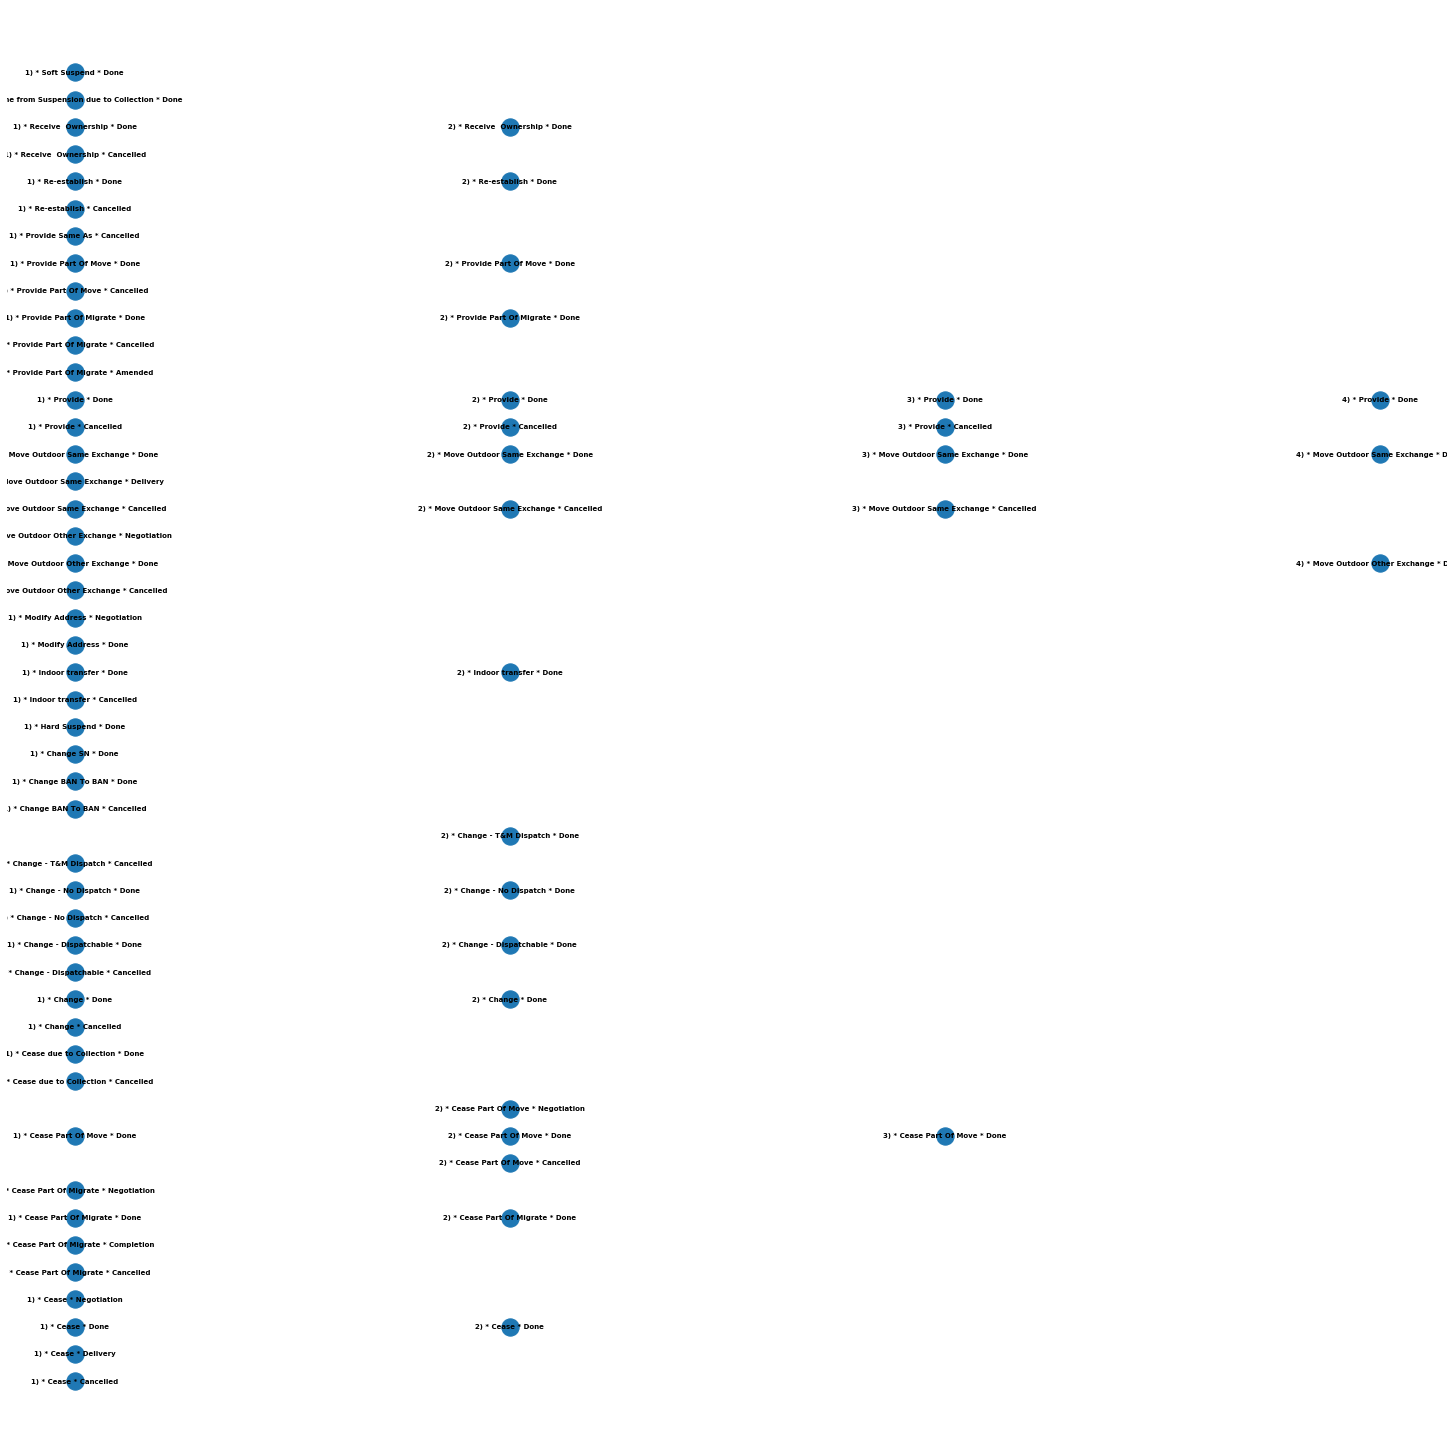

In [49]:
# Draw the resulting graph
pos = nx.get_node_attributes(J,'posi')
nx.draw(J, pos ,with_labels=True, font_weight='bold', font_size = 7)
plt.show()

In [50]:
# clear edges
J.remove_edges_from(list(J.edges()))

In [51]:
#create edges with data (count, days, ave_days)
# accumulated time for nodes

date_col = orders_df.columns.get_loc('ORDER_CREATION_DATE')
kpi = 5

for c in customers:

    temp_df = orders_df[orders_df[unique_col] == c]
  
    for i in range(len(temp_df)-1):
        #print(i, c)
        if J.has_edge(temp_df.iloc[i, -1], temp_df.iloc[(i+1),-1]) == False:
            #print(temp_df.iloc[i, -1], temp_df.iloc[(i+1),-1])
            #print(temp_df.iloc[i,-4], temp_df.iloc[(i+1),-4])
            J.add_edge(temp_df.iloc[i, -1], temp_df.iloc[(i+1),-1])
            J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['count'] = 1
            difference = (temp_df.iloc[(i+1),date_col]-temp_df.iloc[i, date_col])
            J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['days'] = round(difference.total_seconds()/(60*60*24),1)
            J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['ave_days'] = round(J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['days']/ J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['count'],1)
            
            acc_current = J.nodes[temp_df.iloc[(i+1),-1]]['acc_time']
            J.nodes[temp_df.iloc[(i+1),-1]]['acc_time'] = round(acc_current + temp_df.iloc[(i+1),-3].total_seconds()/(60*60*24),1) #-3 is total_time
            #J.nodes[temp_df.iloc[(i+1),-1]]['node_count'] += 1
            
            
            if J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['ave_days'] > kpi:
                J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['color'] = 'red'
            else:
                J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['color'] = 'green'

        else:
            current_count = J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['count']
            J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['count'] = current_count + 1

            current_days =  J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['days']
            difference = (temp_df.iloc[(i+1),date_col]-temp_df.iloc[i, date_col])
            J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['days'] = round(current_days + difference.total_seconds()/(60*60*24),1)

            J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['ave_days'] = round(J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['days']/ J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['count'],1)
            
            acc_current = J.nodes[temp_df.iloc[(i+1),-1]]['acc_time']
            J.nodes[temp_df.iloc[(i+1),-1]]['acc_time'] = round(acc_current + temp_df.iloc[(i+1),-3].total_seconds()/(60*60*24),1) #-3 is total_time         
            #J.nodes[temp_df.iloc[(i+1),-1]]['node_count'] += 1
            
            if J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['ave_days'] > kpi:
                J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['color'] = 'red'
            else:
                J.edges[temp_df.iloc[i, -1],temp_df.iloc[(i+1),-1]]['color'] = 'green'


In [52]:
for j in J.nodes:
    #print(j)
    #print(J.nodes[j]['acc_time'])
    #print(J.nodes[j]['node_count'])
    J.nodes[j]['ave_journey'] = round(J.nodes[j]['acc_time']/J.nodes[j]['node_count'],1)
    

In [53]:
# add edge weight attribute

all_counts = []

#Iterate through the graph edges to gather all the weights
for (node1,node2,data) in J.edges(data=True):
    all_counts.append(data['count']) 

    
total_count = sum(all_counts)
max_count = max(all_counts)
min_count = min(all_counts)
ave_count = total_count/len(all_counts)
scale = 10

print('Total Counts',total_count)
print('Max Count',max_count)
print('Min Count', min_count)
print('Ave Count',ave_count)


if (max_count-min_count) == 0:
    for (node1,node2,data) in J.edges(data=True):
        J.edges[node1,node2]['weight'] = round(J.edges[node1,node2]['count'],1)

else:                                                
    for (node1,node2,data) in J.edges(data=True):
        J.edges[node1,node2]['weight'] = round(((J.edges[node1,node2]['count']-min_count)/(max_count-min_count))*scale+1,1)
    

Total Counts 166
Max Count 102
Min Count 1
Ave Count 5.928571428571429


In [54]:
J.edges(data=True)

EdgeDataView([('2) * Move Outdoor Same Exchange * Cancelled', '3) * Move Outdoor Same Exchange * Cancelled', {'ave_days': 4.9, 'color': 'green', 'weight': 1.0, 'days': 4.9, 'count': 1}), ('2) * Move Outdoor Same Exchange * Cancelled', '1) * Move Outdoor Same Exchange * Cancelled', {'ave_days': 10.5, 'color': 'red', 'weight': 1.1, 'days': 21.0, 'count': 2}), ('2) * Move Outdoor Same Exchange * Cancelled', '3) * Move Outdoor Same Exchange * Done', {'ave_days': 239.0, 'color': 'red', 'weight': 1.0, 'days': 239.0, 'count': 1}), ('2) * Cease * Done', '1) * Cease * Cancelled', {'ave_days': 0.1, 'color': 'green', 'weight': 1.1, 'days': 0.1, 'count': 2}), ('2) * Cease Part Of Move * Cancelled', '1) * Move Outdoor Other Exchange * Cancelled', {'ave_days': 0.0, 'color': 'green', 'weight': 1.1, 'days': 0.0, 'count': 2}), ('2) * Cease Part Of Move * Cancelled', '3) * Cease Part Of Move * Done', {'ave_days': 7.0, 'color': 'red', 'weight': 1.0, 'days': 7.0, 'count': 1}), ('3) * Cease Part Of Move * 

In [55]:
J.nodes(data = True)

NodeDataView({'2) * Move Outdoor Same Exchange * Cancelled': {'acc_time': 21.0, 'posi': (3.01, 33), 'node_count': 2, 'ave_journey': 10.5}, '1) * Cease due to Collection * Done': {'acc_time': 0, 'posi': (1.76, 13), 'node_count': 262, 'ave_journey': 0.0}, '1) * Cease due to Collection * Cancelled': {'acc_time': 0, 'posi': (1.76, 12), 'node_count': 2, 'ave_journey': 0.0}, '2) * Cease Part Of Move * Cancelled': {'acc_time': 0.0, 'posi': (3.01, 9), 'node_count': 2, 'ave_journey': 0.0}, '1) * Cease * Done': {'acc_time': 0, 'posi': (1.76, 3), 'node_count': 615, 'ave_journey': 0.0}, '1) * Provide * Cancelled': {'acc_time': 0, 'posi': (1.76, 36), 'node_count': 22, 'ave_journey': 0.0}, '4) * Move Outdoor Same Exchange * Done': {'acc_time': 53.0, 'posi': (5.51, 35), 'node_count': 1, 'ave_journey': 53.0}, '1) * Move Outdoor Other Exchange * Done': {'acc_time': 0, 'posi': (1.76, 31), 'node_count': 4, 'ave_journey': 0.0}, '3) * Provide * Done': {'acc_time': 0.0, 'posi': (4.26, 37), 'node_count': 1, 

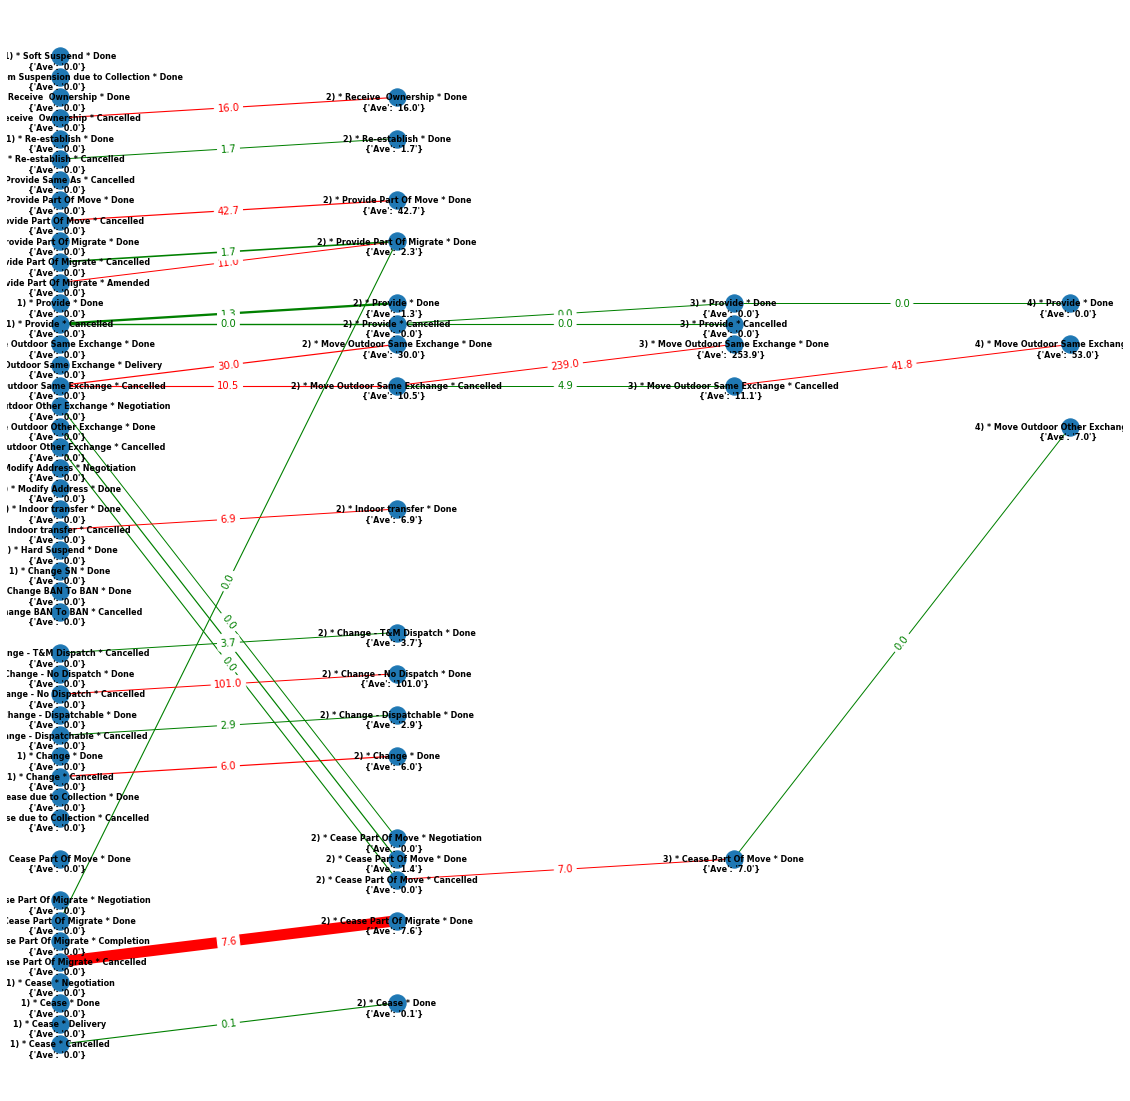

In [56]:
# Draw the resulting graph

#mpl_fig = plt.figure()
mpl_fig, ax = plt.subplots(1,1)

#pos = nx.circular_layout(J)
pos = nx.get_node_attributes(J,'posi')
edges,colors = zip(*nx.get_edge_attributes(J,'color').items())
edges,width = zip(*nx.get_edge_attributes(J,'weight').items())


nx.draw(J,pos, ax=ax, with_labels=True, font_weight='bold', font_size = 8, edgelist=edges, edge_color=colors, width = width
       )

edge_labels  = nx.get_edge_attributes(J,'ave_days')
#label_color  = nx.get_edge_attributes(J,'color').values()

#print(pos)

for e in J.edges(data=True):
    #print(e)
    #print(e[0])
    #print(e[1])
    #print(e[2])
    #print(e[2]['color'])
    nx.draw_networkx_edge_labels(J,ax=ax, pos=pos,edge_labels={(e[0],e[1]):e[2]['ave_days']}, font_color = e[2]['color'])
    

pos_attrs = {}
for node, coords in pos.items():
    pos_attrs[node] = (coords[0] - 0.01, coords[1] - 0.5)

node_attrs = nx.get_node_attributes(J, 'ave_journey')
custom_node_attrs = {}
for node, attr in node_attrs.items():
    custom_node_attrs[node] = "{'Ave': '" + str(attr) + "'}"

nx.draw_networkx_labels(J, pos_attrs, labels=custom_node_attrs, font_weight='bold', font_size = 8)

plt.savefig('stage_transition_edge_colour')
plt.show()

In [57]:
#Create Edges
def make_edge(x, y, width, color):
    """
    Args:
        x: a tuple of the x from and to, in the form: tuple([x0, x1, None])
        y: a tuple of the y from and to, in the form: tuple([y0, y1, None])
        width: The width of the line

    Returns:
        a Scatter plot which represents a line between the two points given. 
    """
    return  go.Scatter(
                x=x,
                y=y,
                text = hover_txt,
                line=dict(width=width,color=color),
                hoverinfo=None,
                mode='lines')

In [58]:
#Create Edges hover text
def edge_hover(x, y, hover_txt, color):
    """
    Args:
        x: a tuple of the x from and to, in the form: tuple([x0, x1, None])
        y: a tuple of the y from and to, in the form: tuple([y0, y1, None])
        width: The width of the line

    Returns:
        a Scatter plot which represents a line between the two points given. 
    """
    return  go.Scatter(
                x=x,
                y=y,
                text = hover_txt,
                mode='markers',
                hoverinfo='text',
                hoverlabel = dict(
                            bgcolor = color,
                            font =  dict(color = 'white')
                            ),
                marker=go.Marker(opacity=0.1, symbol = 'triangle-left')
                )

In [59]:
data_trace = []

In [60]:
p_0=5
p_1=4

In [61]:
for edge in J.edges(data=True):
    x0, y0 = J.nodes[edge[0]]['posi']
    x1, y1 = J.nodes[edge[1]]['posi']
    
    x=tuple([x0, x1, None])
    y=tuple([y0, y1, None])
    
    xh = tuple([(x0/(p_0+p_1)*p_0+x1/(p_0+p_1)*p_1),None])
    yh = tuple([(y0/(p_0+p_1)*p_0+y1/(p_0+p_1)*p_1),None])
    
    #print(edge)
    
    width = edge[2]['weight']
    color = edge[2]['color']
    hover_txt = 'Count: '+ str(round(edge[2]['count'],1)) + '<br />Ave_days: ' + str(round(edge[2]['days']/edge[2]['count'],1))
    
    #print(width)
    
    data_trace.append(make_edge(x,y,width,color))
    #if else
    data_trace.append(edge_hover(xh,yh,hover_txt,color))
    

/usr/local/lib/python3.5/dist-packages/plotly/graph_objs/_deprecations.py:441: DeprecationWarning:

plotly.graph_objs.Marker is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Marker
  - plotly.graph_objs.histogram.selected.Marker
  - etc.




In [62]:
#data_trace

In [63]:
node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='Blackbody',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=2)))

for node in J.nodes():
    x, y = J.nodes[node]['posi']
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])

In [64]:
for node in J.nodes(data=True):
    #print(node)
    node_trace['marker']['color']+=tuple([node[1]['node_count']])
    node_info = node[0]+ '<br />Journeys: ' +str(node[1]['node_count']) + '<br />Ave_journey: '+str(round(node[1]['acc_time']/node[1]['node_count'],1))
    node_trace['text']+=tuple([node_info])

In [65]:
data_trace.append(node_trace)

In [66]:
label_size = max(round(16-(len(type_status)/6),0),4)

In [67]:
label_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='text',
    hoverinfo='none',
    opacity=0.8,
    textposition='middle right',
    textfont=dict( size = label_size,
                  color='#888'
                 )
    )

for label in L.nodes():
    x, y = L.nodes[label]['posi']
    #print(L.nodes[label]['posi'])
    label_trace['x'] += tuple([x])
    label_trace['y'] += tuple([y])
    label_trace['text']+= tuple([label])


In [68]:
#label_trace['text']

In [69]:
data_trace.append(label_trace)

In [70]:
fig = go.Figure(data=data_trace,
             layout=go.Layout(
                title='<br>Network graph made with Python',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Python code: <a href='https://plot.ly/ipython-notebooks/network-graphs/'> https://plot.ly/ipython-notebooks/network-graphs/</a>",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

In [71]:
ply.offline.plot(fig, filename='order_stages_with_label.html')

'order_stages_with_label.html'

In [72]:
app = dash.Dash()

In [73]:
app.layout = html.Div([
    html.Div([html.H1("Networkx Stage Graph")], className="row", style={'textAlign': "center"}),
    html.Div([dcc.Graph(id="my-graph", figure = fig)]),
], className="container")

In [74]:
if __name__ == '__main__':
    app.run_server(debug=True)

Running on http://127.0.0.1:8050/
Debugger PIN: 031-165-320
 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


SystemExit: 1

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3334: UserWarning:

To exit: use 'exit', 'quit', or Ctrl-D.

